## Load parquet

In [63]:
import logging
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import pandas_ta as ta

from preprocess import preprocess_data

In [3]:
df = pd.read_parquet("3_years_500_stocks.parquet")

# Try to predict buy sell signal

## Load data

In [13]:
training_df = df[df["instrument_id"] == 318]
training_df.head()

,instrument_id,ts,open_price,close_price,high_price,low_price,volume
7521,318,2018-01-23 23:10:00+00:00,43.53,43.53,43.53,43.53,200.0
7522,318,2018-01-23 22:50:00+00:00,43.60,43.59,43.60,43.59,125.0
7523,318,2018-01-23 22:45:00+00:00,43.58,43.58,43.58,43.58,680.0
7524,318,2018-01-23 22:30:00+00:00,43.59,43.52,43.59,43.52,1649.0
7525,318,2018-01-23 22:25:00+00:00,43.59,43.58,43.59,43.58,1303.0


## Add buy sell points

### Add technical signals

In [14]:
training_df = preprocess_data(training_df)

### Add Buy sell bot signals

In [21]:
from bot import TradingBot

# Test bot
bot = TradingBot(initial_budget=1000,
                rsi_oversold_threshold=20,
                rsi_overbought_threshold=80,
                stop_loss=0.02)
# Initial reset
bot.reset()
# Init list for collecting bot ops
bot_ops_list = []
# Go over all rows
for index, data in training_df.iterrows():
    bot_ops_list.append(bot.process(data))
# Create series
bot_ops_series = pd.Series(bot_ops_list)
# Add new column
training_df["bot_op"] = bot_ops_series

### Plot operations

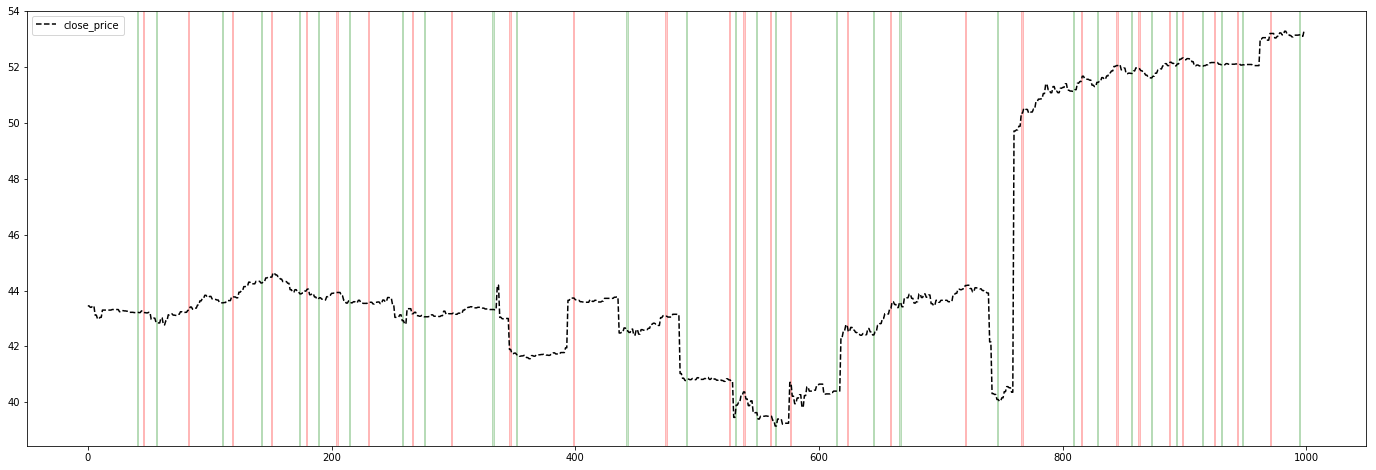

In [25]:
logging.getLogger().setLevel(logging.INFO)

plot_df = training_df.iloc[:1000]

plt.figure(figsize=(24,8))
ax = plot_df["close_price"].plot(color="black", linestyle='--')
# Show buy moments
for x in plot_df[plot_df["bot_op"] == 1].index:
    ax.axvspan(x, x+1, alpha=0.2, color="green")   
# Show sell moments
for x in plot_df[plot_df["bot_op"] == 2].index:
    ax.axvspan(x, x+1, alpha=0.2, color="red")   
plt.legend()

## Prepare dataset

In [155]:
# Select features
X = training_df[["MACD","MACDs","MACDh","RSI"]].values
# Normalize 
X_norm_dict = [10,10,10,100]
X /= X_norm_dict
print(X.shape)

# Select targets
Y = pd.get_dummies(training_df["bot_op"]).values
print(Y.shape)

(214182, 4)
(214182, 3)


### Add previous data to dataset

In [161]:
window_size = 5

X_windowed = np.ndarray((X.shape[0],window_size,X.shape[1]))

for i in range(window_size,X.shape[0]):
    X_windowed[i] = X[i-window_size:i]

# Reshape
X_windowed = X_windowed.reshape(X_windowed.shape[0],X_windowed.shape[2],X_windowed.shape[1],1)
X_windowed.shape

(214182, 4, 5, 1)

### Create test and train datasets

In [162]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_windowed, Y, test_size=0.3)

### Create model

In [179]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

model = Sequential()
#First Hidden Layer
model.add(Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
#Second  Hidden Layer
model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
# Flat transformation
model.add(Flatten())
# Output Layer
model.add(Dense(128, activation='relu'))
model.add(Dense(3,  activation='softmax'))

#Compiling the neural network
model.compile(optimizer ='adam',loss='categorical_crossentropy', metrics =['accuracy'])

model.summary()

# Fitting the data to the training dataset
his = model.fit(X_train, Y_train, batch_size=32, epochs=100, validation_split=0.1)

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 4, 5, 32)          320       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 2, 2, 32)          0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 2, 2, 64)          18496     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_50 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_51 (Dense)             (None, 3)               

In [181]:
import sklearn

Y_pred = model.predict(X_test)

sklearn.metrics.classification_report(Y_test, Y_pred)

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

In [ ]:
model.evaluate(X_test, Y_test)